In [49]:
import matplotlib.pyplot as plt
import numpy as np
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
import umap.umap_ as umap
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
from tqdm import tqdm

In [50]:
# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),  # normalize the dataset to range [-1, 1]
    transforms.RandomRotation(10),  # rotate the image randomly by 10 degrees
    transforms.RandomHorizontalFlip()  # flip the image horizontally with a 50% probability
])

# Download and load the training data
trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# Create indices for training and validation splits
num_train = len(trainset)
indices = list(range(num_train))
np.random.shuffle(indices)

# Define split size
split = int(0.2 * num_train)  # 20% for validation
train_idx, val_idx = indices[split:], indices[:split]

# Create samplers for training and validation
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

# Create data loaders with samplers
trainloader = DataLoader(trainset, batch_size=64, sampler=train_sampler)
valloader = DataLoader(trainset, batch_size=64, sampler=val_sampler)

# Download and load the test data
testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

In [51]:
# Let's check if our data is loaded correctly
images, labels = next(iter(trainloader))

print(images.shape)
print(len(trainloader))
print(labels.shape)
print(len(testloader))

# Check each sample in the dataset
missing_samples = any(img is None or lbl is None for img, lbl in trainset)

if missing_samples:
    print("Missing data detected in individual samples.")
else:
    print("No missing data found in individual samples.")

torch.Size([64, 1, 28, 28])
750
torch.Size([64])
157
No missing data found in individual samples.


In [52]:
unique_labels, counts = np.unique(trainset.targets, return_counts=True)
print(f"Unique labels: {unique_labels}")
print(f"Counts: {counts}")

print("Number of samples per digit:")
for label, count in zip(unique_labels, counts):
    print(f"Digit {label}: {count}")

# Check if the data distribution is balanced
total_samples = len(trainset.targets)
min_samples = min(counts)
max_samples = max(counts)
balance_ratio = min_samples / max_samples

print(f"\nTotal samples: {total_samples}")
print(f"Balance ratio (min/max): {balance_ratio}")

Unique labels: [0 1 2 3 4 5 6 7 8 9]
Counts: [6000 6000 6000 6000 6000 6000 6000 6000 6000 6000]
Number of samples per digit:
Digit 0: 6000
Digit 1: 6000
Digit 2: 6000
Digit 3: 6000
Digit 4: 6000
Digit 5: 6000
Digit 6: 6000
Digit 7: 6000
Digit 8: 6000
Digit 9: 6000

Total samples: 60000
Balance ratio (min/max): 1.0


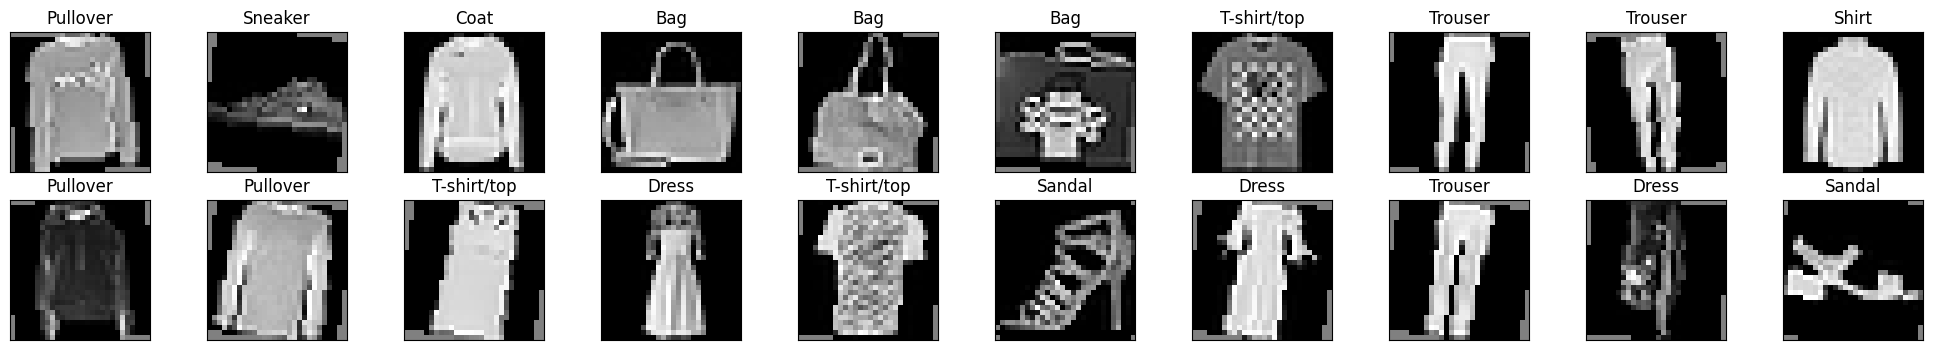

In [53]:
# Let's plot all the unique labels from the dataset
# Define the text labels
text_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(text_labels[labels[idx].item()])
plt.show()

In [54]:
class SimpleCNNImage(nn.Module):
    def __init__(self, dropout=0.45, kernel_size=3, num_classes=10):
        super(SimpleCNNImage, self).__init__()

        # First Convolutional Layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=kernel_size, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization added
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second Convolutional Layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_size, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # Batch normalization added
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()

        # Fully Connected Layers
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.bn3 = nn.BatchNorm1d(512)  # Batch normalization added
        self.relu3 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.fc2 = nn.Linear(512, 128)
        self.bn4 = nn.BatchNorm1d(128)  # Batch normalization added
        self.relu4 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        # Output Layer
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.flatten(x)
        x = self.dropout1(self.relu3(self.bn3(self.fc1(x))))
        x = self.dropout2(self.relu4(self.bn4(self.fc2(x))))
        x1 = x
        x = self.fc3(x)
        return x1, x

In [63]:
# Define the objective function for Optuna
def objective(trial):
    device_index = 0  # Use the first GPU by default
    if torch.cuda.is_available() and device_index < torch.cuda.device_count():
        device = torch.device(f"cuda:{device_index}")
        print(f"Using device: {torch.cuda.get_device_name(device_index)}")
    else:
        device = torch.device("cpu")
        print("Using CPU as no valid CUDA device is available.")
        
    # Suggest hyperparameters to tune
    # dropout = trial.suggest_float('dropout', 0.3, 0.6)
    # learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    # num_epochs = trial.suggest_int('num_epochs', 5, 20)
    
    # Settings for quick test    
    dropout = trial.suggest_float('dropout', 0.3, 0.3)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-4, log=True)
    num_epochs = trial.suggest_int('num_epochs', 5, 5)
    
    # Initialize the model, criterion, and optimizer with suggested parameters
    model = SimpleCNNImage(dropout=dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(
        model, criterion, optimizer, trainloader, valloader, device, num_epochs
    )

    # Return the best validation accuracy (maximize)
    return max(valid_accuracies)

In [64]:
def train_model(model, criterion, optimizer, train_loader, valid_loader, device, num_epochs=10):
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            _, outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_losses.append(running_train_loss / len(train_loader))
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        running_valid_loss = 0.0
        correct_valid = 0
        total_valid = 0

        with torch.no_grad():
            for images, labels in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                images = images.to(device)
                labels = labels.to(device)
                
                _, outputs = model(images)
                loss = criterion(outputs, labels)

                running_valid_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_valid += labels.size(0)
                correct_valid += (predicted == labels).sum().item()

        valid_losses.append(running_valid_loss / len(valid_loader))
        valid_accuracy = 100 * correct_valid / total_valid
        valid_accuracies.append(valid_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Valid Loss: {valid_losses[-1]:.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}%, Valid Accuracy: {valid_accuracy:.2f}%")

    # Plotting
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(valid_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return train_losses, valid_losses, train_accuracies, valid_accuracies

[I 2024-11-06 01:38:01,054] A new study created in memory with name: no-name-53b64c68-c7f8-4964-945c-212ee327437e


Using device: NVIDIA GeForce RTX 4050 Laptop GPU
Using device: NVIDIA GeForce RTX 4050 Laptop GPU


Epoch 1/5 - Validation: 100%|██████████| 188/188 [00:04<00:00, 38.92it/s]


Epoch 1/5, Train Loss: 0.6827, Valid Loss: 0.4155, Train Accuracy: 81.09%, Valid Accuracy: 86.45%


Epoch 2/5 - Validation: 100%|██████████| 188/188 [00:04<00:00, 41.42it/s]


Epoch 2/5, Train Loss: 0.3994, Valid Loss: 0.3403, Train Accuracy: 87.15%, Valid Accuracy: 87.96%


Epoch 3/5 - Validation: 100%|██████████| 188/188 [00:04<00:00, 40.95it/s]


Epoch 3/5, Train Loss: 0.3422, Valid Loss: 0.3117, Train Accuracy: 88.22%, Valid Accuracy: 88.78%


Epoch 4/5 - Validation: 100%|██████████| 188/188 [00:04<00:00, 41.24it/s]


Epoch 4/5, Train Loss: 0.3079, Valid Loss: 0.2901, Train Accuracy: 89.25%, Valid Accuracy: 89.56%


Epoch 5/5 - Validation: 100%|██████████| 188/188 [00:07<00:00, 23.94it/s]


Epoch 5/5, Train Loss: 0.2895, Valid Loss: 0.2786, Train Accuracy: 89.83%, Valid Accuracy: 89.81%


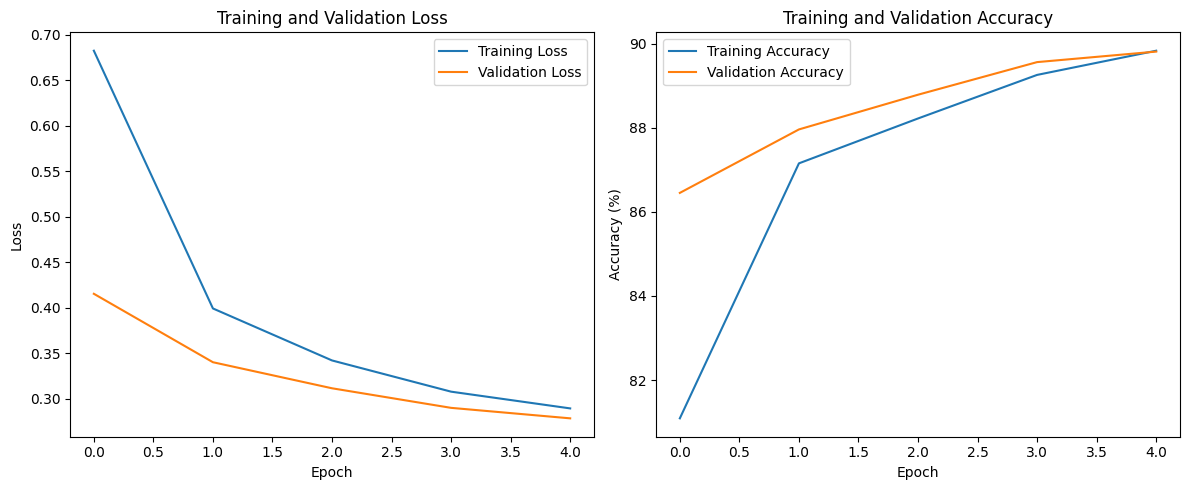

[I 2024-11-06 01:40:44,928] Trial 0 finished with value: 89.80833333333334 and parameters: {'dropout': 0.3, 'learning_rate': 0.0001, 'num_epochs': 5}. Best is trial 0 with value: 89.80833333333334.


Best parameters found:
{'dropout': 0.3, 'learning_rate': 0.0001, 'num_epochs': 5}


Epoch 1/5 - Validation: 100%|██████████| 188/188 [00:04<00:00, 39.78it/s]


Epoch 1/5, Train Loss: 0.6764, Valid Loss: 0.4161, Train Accuracy: 80.74%, Valid Accuracy: 86.47%


Epoch 2/5 - Validation: 100%|██████████| 188/188 [00:04<00:00, 39.21it/s]


Epoch 2/5, Train Loss: 0.3999, Valid Loss: 0.3331, Train Accuracy: 86.91%, Valid Accuracy: 88.11%


Epoch 3/5 - Validation: 100%|██████████| 188/188 [00:04<00:00, 39.64it/s]


Epoch 3/5, Train Loss: 0.3421, Valid Loss: 0.3143, Train Accuracy: 88.26%, Valid Accuracy: 88.81%


Epoch 4/5 - Validation: 100%|██████████| 188/188 [00:04<00:00, 39.29it/s]


Epoch 4/5, Train Loss: 0.3129, Valid Loss: 0.2917, Train Accuracy: 89.12%, Valid Accuracy: 89.28%


Epoch 5/5 - Validation: 100%|██████████| 188/188 [00:05<00:00, 36.95it/s]


Epoch 5/5, Train Loss: 0.2900, Valid Loss: 0.2745, Train Accuracy: 89.84%, Valid Accuracy: 89.91%


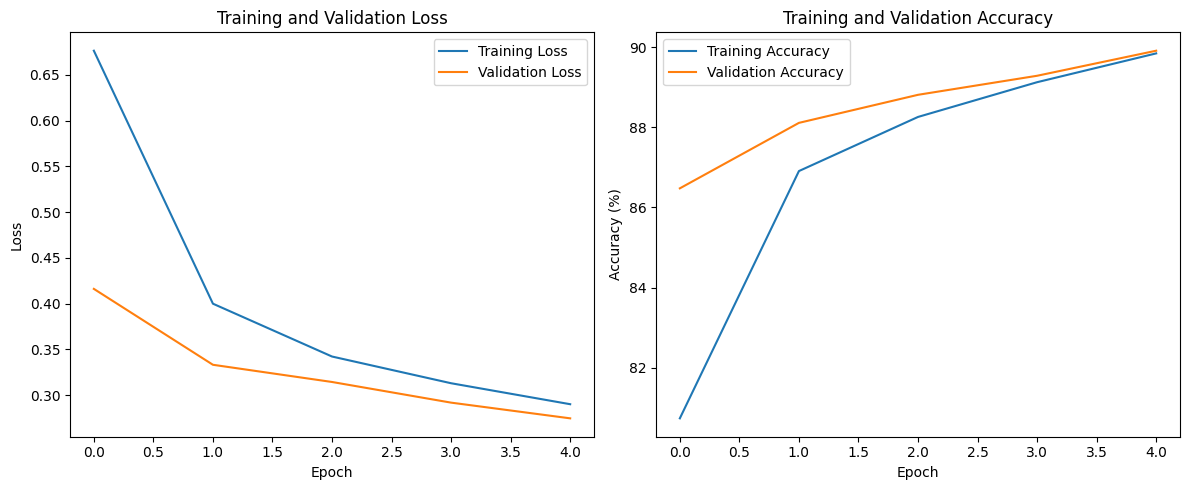

Model state dict saved to best_model_state.pth


In [65]:
model_path = "best_model_state.pth"
best_model = SimpleCNNImage(dropout=0.45)
criterion = nn.CrossEntropyLoss()

# Check for available CUDA devices
device_index = 0  # Use the first GPU by default
if torch.cuda.is_available() and device_index < torch.cuda.device_count():
    device = torch.device(f"cuda:{device_index}")
    print(f"Using device: {torch.cuda.get_device_name(device_index)}")
else:
    device = torch.device("cpu")
    print("Using CPU as no valid CUDA device is available.")

try:
    best_model.load_state_dict(torch.load(model_path, weights_only=True))
    best_model.eval()
except:
    # Create a study and optimize
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=1)

    # Print best parameters
    print("Best parameters found:")
    print(study.best_params)

    # Evaluate on the testing set with the best model
    best_params = study.best_params
    best_model = SimpleCNNImage(dropout=best_params['dropout']).to(device)
    optimizer = optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])
    train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(
        best_model, criterion, optimizer, trainloader, valloader, device, best_params['num_epochs']
    )

    # Save the model state dict
    model_path = "best_model_state.pth"
    torch.save(best_model.state_dict(), model_path)
    print(f"Model state dict saved to {model_path}")

In [72]:
# Evaluate on the testing set
best_model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for images, labels in tqdm(testloader, desc="Testing"):
        images = images.view(-1, 1, 28, 28)
        images = images.float().to(device)
        labels = labels.to(device)
        _, outputs = best_model(images)
        loss = criterion(outputs.to(device), labels)

        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy = 100 * correct_test / total_test
print(f"Test Loss: {test_loss / len(testloader):.4f}, Test Accuracy: {test_accuracy:.2f}%")


Testing: 100%|██████████| 157/157 [00:04<00:00, 37.47it/s]

Test Loss: 0.2841, Test Accuracy: 89.40%


In [73]:
# Function to extract embeddings
def extract_embeddings(model, image_train_loader):
    embeddings = []
    labels = []
    with torch.no_grad():
        for image_data, image_labels in tqdm((image_train_loader), desc=f"Extracting"):
            image_input = image_data.view(-1, 1, 28, 28).float()
            image_embedding, _ = model(image_input.to(device))
            embeddings.append(image_embedding)
            labels.append(image_labels)
    embeddings = torch.cat(embeddings)
    labels = torch.cat(labels)
    return embeddings, labels

# Extract embeddings for training data
train_embeddings, train_labels = extract_embeddings(best_model, trainloader)

Extracting: 100%|██████████| 750/750 [00:15<00:00, 47.09it/s]


Number of components for 90% explained variance: 9


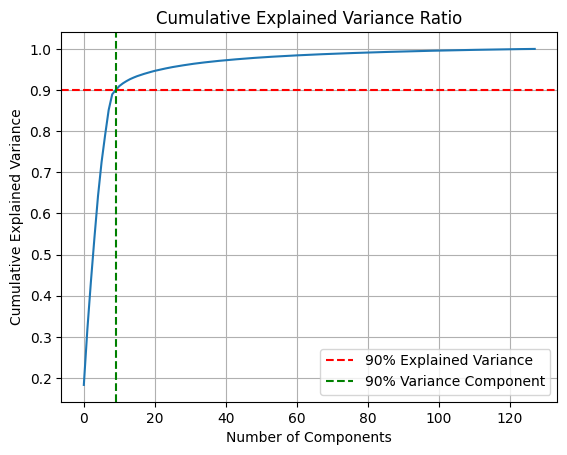

In [74]:
# Fit PCA
pca = PCA()
pca.fit(train_embeddings.cpu())

# Calculate cumulative explained variance ratio
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the index where cumulative explained variance ratio first surpasses 0.9
index_90_percent = np.argmax(cumulative_variance >= 0.9)
print(f"Number of components for 90% explained variance: {index_90_percent}")

# Plot cumulative explained variance ratio
plt.plot(cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance Ratio')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Explained Variance')
plt.axvline(x=index_90_percent, color='g', linestyle='--', label='90% Variance Component')
plt.grid(True)
plt.legend()
# output_path = os.path.join(output_dir, 'Cumulative Explained Variance Ratio Image.png')
# plt.savefig(output_path)
plt.show()

In [75]:
# Function to apply PCA
def apply_pca(embeddings, n_components):
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(embeddings)
    return pca_result

# Apply PCA
num_components = 8  # You can choose any number of components
pca_embeddings = apply_pca(train_embeddings.cpu(), num_components)

In [76]:
print("pca_embeddings data type:", type(pca_embeddings))
print("pca_embeddings shape:", pca_embeddings.shape)

# Check the data type and shape of labels
train_labels_np = train_labels.numpy()
print("labels data type:", type(train_labels_np))
print("labels shape:", train_labels_np.shape)

pca_embeddings data type: <class 'numpy.ndarray'>
pca_embeddings shape: (48000, 8)
labels data type: <class 'numpy.ndarray'>
labels shape: (48000,)


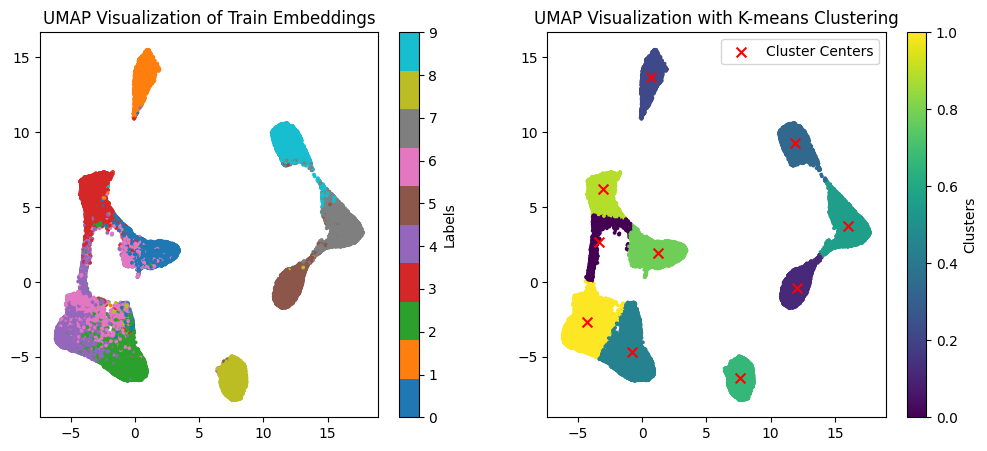

In [77]:
# Function to apply UMAP, visualize embeddings, and perform k-means clustering
def visualize_umap_with_clustering(embeddings, labels, num_clusters):
    # Apply UMAP for dimensionality reduction
    umap_result = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.0, metric='euclidean').fit_transform(embeddings)

    # Plot UMAP embeddings
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(umap_result[:, 0], umap_result[:, 1], c=labels, cmap='tab10', s=3)
    plt.title('UMAP Visualization of Train Embeddings')
    plt.colorbar(label='Labels')
#     output_path = os.path.join(output_dir, 'UMAP Visualization of Train Embeddings Image.png')
#     plt.savefig(output_path)

    # Apply k-means clustering
    kmeans = KMeans(n_clusters=num_clusters)
    cluster_labels = kmeans.fit_predict(umap_result)
    cluster_centers = kmeans.cluster_centers_  # Get cluster centers

    # Plot UMAP embeddings with cluster assignments and cluster centers
    plt.subplot(1, 2, 2)
    plt.scatter(umap_result[:, 0], umap_result[:, 1], c=cluster_labels, cmap='viridis', s=3)
    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x', s=50, label='Cluster Centers')
    plt.title('UMAP Visualization with K-means Clustering')
    plt.colorbar(label='Clusters')
    plt.legend()
#     output_path = os.path.join(output_dir, 'UMAP Visualization with K-means Clustering Image.png')
#     plt.savefig(output_path)
    plt.show()

# Assuming you have your embeddings stored in pca_embeddings and labels in train_labels_np
# Also, assuming the number of clusters is 10
visualize_umap_with_clustering(pca_embeddings, train_labels_np, num_clusters=10)